In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def logl_interp(x, x0, x1, y0, y1):
    return np.exp(np.log(y0) + (x - x0) * np.log(y1 / y0) / (x1 - x0))

In [3]:
df = pd.read_csv("options1.csv")
df = df.sort_values(["Time to maturity", "Strike"]).reset_index(drop=True)
df

,Strike,Time to maturity,Call,Put
0,70,0.25,31.187760,0.990001
1,75,0.25,26.603548,1.356038
2,80,0.25,22.129710,1.832449
3,85,0.25,17.798497,2.451485
4,90,0.25,13.656085,3.259322
...,...,...,...,...
99,110,2.00,13.010976,18.474831
100,115,2.00,10.607695,20.687131
101,120,2.00,8.458015,23.153033
102,125,2.00,6.590732,25.901332


In [4]:
maturities = df["Time to maturity"].unique()

df["Rates"] = None

for maturity in maturities:
    # We don't know which strike contains the error so to compute the rates we will use three different pairs of strikes and take the one 
    # that is consistent between at least two of them.

    r1 = (df[(df["Time to maturity"] == maturity) & (df["Strike"] == 70)]["Call"].values[0]
    - df[(df["Time to maturity"] == maturity) & (df["Strike"] == 70)]["Put"].values[0]
    - df[(df["Time to maturity"] == maturity) & (df["Strike"] == 75)]["Call"].values[0]
    + df[(df["Time to maturity"] == maturity) & (df["Strike"] == 75)]["Put"].values[0])/5

    r2 = (df[(df["Time to maturity"] == maturity) & (df["Strike"] == 80)]["Call"].values[0]
    - df[(df["Time to maturity"] == maturity) & (df["Strike"] == 80)]["Put"].values[0]
    - df[(df["Time to maturity"] == maturity) & (df["Strike"] == 85)]["Call"].values[0]
    + df[(df["Time to maturity"] == maturity) & (df["Strike"] == 85)]["Put"].values[0])/5

    r3 = (df[(df["Time to maturity"] == maturity) & (df["Strike"] == 90)]["Call"].values[0]
    - df[(df["Time to maturity"] == maturity) & (df["Strike"] == 90)]["Put"].values[0]
    - df[(df["Time to maturity"] == maturity) & (df["Strike"] == 95)]["Call"].values[0]
    + df[(df["Time to maturity"] == maturity) & (df["Strike"] == 95)]["Put"].values[0])/5

    # If r1 != r2 then either r1 or r2 is wrong, if r2 != r3 that means r1==r3 
    df.loc[df["Time to maturity"] == maturity, "Rates"] = r1 if r1 == r2 else r2 if r2 == r3 else r3


df["Dividends"] = (df["Call"] - df["Put"] + df["Rates"]*df["Strike"])/100
df

,Strike,Time to maturity,Call,Put,Rates,Dividends
0,70,0.25,31.187760,0.990001,0.99005,0.995012
1,75,0.25,26.603548,1.356038,0.99005,0.995012
2,80,0.25,22.129710,1.832449,0.99005,0.995012
3,85,0.25,17.798497,2.451485,0.99005,0.995012
4,90,0.25,13.656085,3.259322,0.99005,0.995012
...,...,...,...,...,...,...
99,110,2.00,13.010976,18.474831,0.923116,0.960789
100,115,2.00,10.607695,20.687131,0.923116,0.960789
101,120,2.00,8.458015,23.153033,0.923116,0.960789
102,125,2.00,6.590732,25.901332,0.923116,0.960789


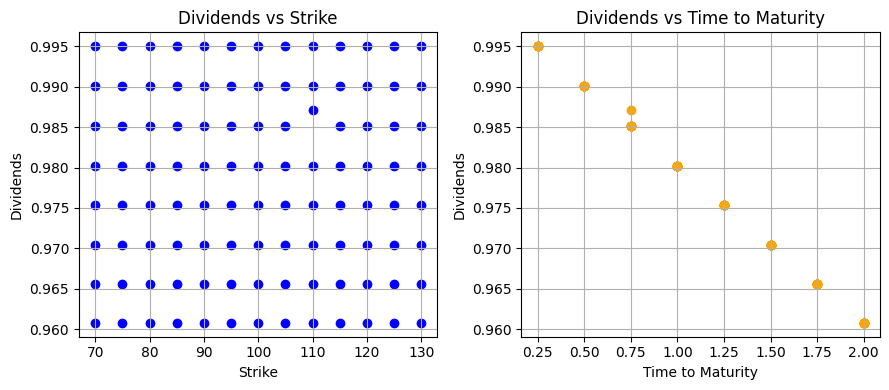

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].scatter(df["Strike"], df["Dividends"], color="blue")
axs[0].set_title("Dividends vs Strike")
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Dividends")
axs[0].grid(True)

axs[1].scatter(df["Time to maturity"], df["Dividends"], color="orange")
axs[1].set_title("Dividends vs Time to Maturity")
axs[1].set_xlabel("Time to Maturity")
axs[1].set_ylabel("Dividends")
axs[1].grid(True)


plt.tight_layout()
plt.show()

Visually we identifie a likely mispriced option at strike = 110 and maturity = 0.75.

In [6]:
mispriced = df[(df["Time to maturity"] == 0.75) & (df["Strike"] == 110)]
next_correct = df[(df["Time to maturity"] == 0.75) & (df["Strike"] == 115)]
mispriced

,Strike,Time to maturity,Call,Put,Rates,Dividends
34,110,0.75,5.564298,13.602112,0.970446,0.987112


In [7]:
print("Given C - P: ", mispriced["Call"].values[0] - mispriced["Put"].values[0])
print("Correct C - P: ", next_correct["Dividends"].values[0] *100 - next_correct["Rates"].values[0] * mispriced["Strike"].values[0])

Given C - P:  -8.037814730029691
Correct C - P:  -8.237814730029669


Hence the call is either overpriced or the put is underpriced. 
Then to lock in a riskless profit we can sell the call, buy the put (as we don't know which one is overpriced or underpriced) and do the opposite with the next strike (115)


At t=0, we short a call and long a put at K1, and long a call and short a put at K2 The initial profit is 5.052227667742528
At maturity, the total payoff of the options is -5.0
Hence the total payoff at maturity including interest rates on the initial cost is 0.20609090679066888


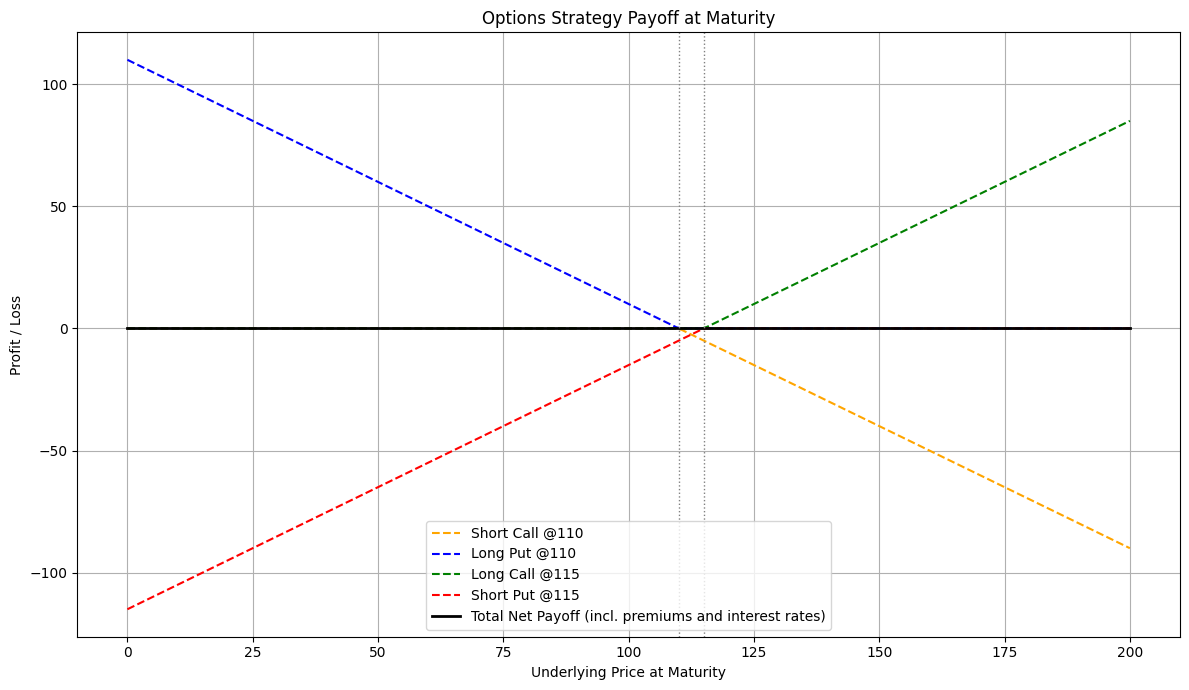

In [8]:
K1 = 110
K2 = 115

T = 0.75

call_K1 = df[(df["Time to maturity"] == 0.75) & (df["Strike"] == K1)]["Call"].values[0]
put_K1 = df[(df["Time to maturity"] == 0.75) & (df["Strike"] == K1)]["Put"].values[0]

call_K2 = df[(df["Time to maturity"] == 0.75) & (df["Strike"] == K2)]["Call"].values[0]
put_K2 = df[(df["Time to maturity"] == 0.75) & (df["Strike"] == K2)]["Put"].values[0]

S = np.linspace(0, 200, 200)

payoff_call_K1 = -np.maximum(S - K1, 0)  
payoff_put_K1 = np.maximum(K1 - S, 0)    
payoff_call_K2 = np.maximum(S - K2, 0)   
payoff_put_K2 = -np.maximum(K2 - S, 0)  

payoff_total = payoff_call_K1 + payoff_put_K1 + payoff_call_K2 + payoff_put_K2

initial_cost = call_K1 - put_K1 - call_K2 + put_K2
total_payoff_net = payoff_total + initial_cost/df[(df["Time to maturity"] == 0.75) & (df["Strike"] == K1)]["Rates"].values[0]
print(f"At t=0, we short a call and long a put at K1, and long a call and short a put at K2",end="")
print(" The initial cost is {abs(initial_cost)}" if initial_cost < 0 else f" The initial profit is {initial_cost}")
print(f"At maturity, the total payoff of the options is {payoff_total.mean()}")
print(f"Hence the total payoff at maturity including interest rates on the initial cost is {total_payoff_net.mean()}")

plt.figure(figsize=(12, 7))

plt.plot(S, payoff_call_K1, label=f'Short Call @{K1}', linestyle='--', color='orange')
plt.plot(S, payoff_put_K1, label=f'Long Put @{K1}', linestyle='--', color='blue')
plt.plot(S, payoff_call_K2, label=f'Long Call @{K2}', linestyle='--', color='green')
plt.plot(S, payoff_put_K2, label=f'Short Put @{K2}', linestyle='--', color='red')

plt.plot(S, total_payoff_net, label='Total Net Payoff (incl. premiums and interest rates)', color='black', linewidth=2)

plt.axvline(K1, color='gray', linestyle=':', linewidth=1)
plt.axvline(K2, color='gray', linestyle=':', linewidth=1)

plt.title("Options Strategy Payoff at Maturity")
plt.xlabel("Underlying Price at Maturity")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df2 = pd.read_csv("options2.csv")
df2 = df2.sort_values(["Time to maturity", "Strike"]).reset_index(drop=True)
df2

,Strike,Time to maturity,Call
0,70,0.25,50.783429
1,75,0.25,46.056133
2,80,0.25,41.383537
3,85,0.25,36.776369
4,90,0.25,32.247646
...,...,...,...
115,120,2.00,23.694532
116,125,2.00,20.900004
117,130,2.00,18.249426
118,135,2.00,15.758874


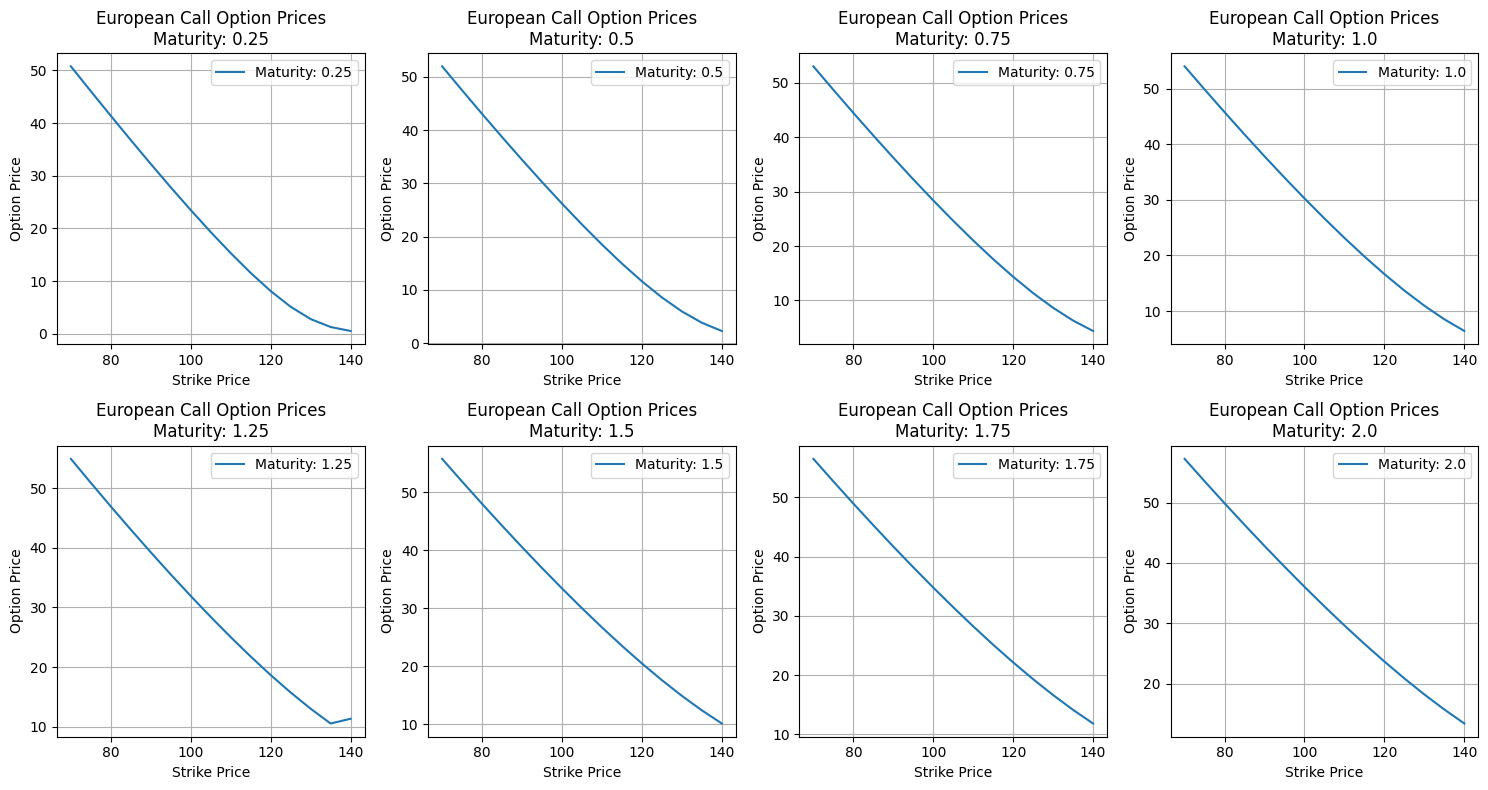

In [10]:
maturities = df2['Time to maturity'].unique()

num_maturities = len(maturities)
cols = 4
rows = (num_maturities // cols) + (num_maturities % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

axes = axes.flatten()

for i, maturity in enumerate(maturities):
    data = df2[df2['Time to maturity'] == maturity]
    axes[i].plot(data['Strike'], data['Call'], label=f'Maturity: {maturity}')
    axes[i].set_title(f'European Call Option Prices\nMaturity: {maturity}')
    axes[i].set_xlabel('Strike Price')
    axes[i].set_ylabel('Option Price')
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
df2[df2["Time to maturity"] == 1.25].tail(3)

,Strike,Time to maturity,Call
72,130,1.25,13.030055
73,135,1.25,10.548815
74,140,1.25,11.339072


We observe that the call option with a maturity of 1.25 and a strike price of 140 is priced higher than the call option with the same maturity but a strike price of 135 which should not be the case.
We can sell the call with a strike price of 140 and buy the call with a strike price of 135 to lock in a riskless profit.
At t = 0 we get a profit of 5 and at maturity we get a profit of 0.790257
At maturity if the stock price is less than 135 we don't have any additional profit or loss. 
If the stock price is between 135 and 140 we have a profit of ST - 135 + initial profit + interest on the initial profit.
If the stock price above 140 we have a total profit of 5 + initial profit + interest on the initial profit.

In [12]:
df3 = pd.read_csv("options3.csv")
df3 = df3.sort_values(["TTM", "Strike"]).reset_index(drop=True)
df3

,Strike,TTM,Call
0,70,0.25,55.337094
1,75,0.25,50.495530
2,80,0.25,45.688852
3,85,0.25,40.926018
4,90,0.25,36.218113
...,...,...,...
115,120,2.00,23.404063
116,125,2.00,20.346413
117,130,2.00,17.442311
118,135,2.00,14.714251


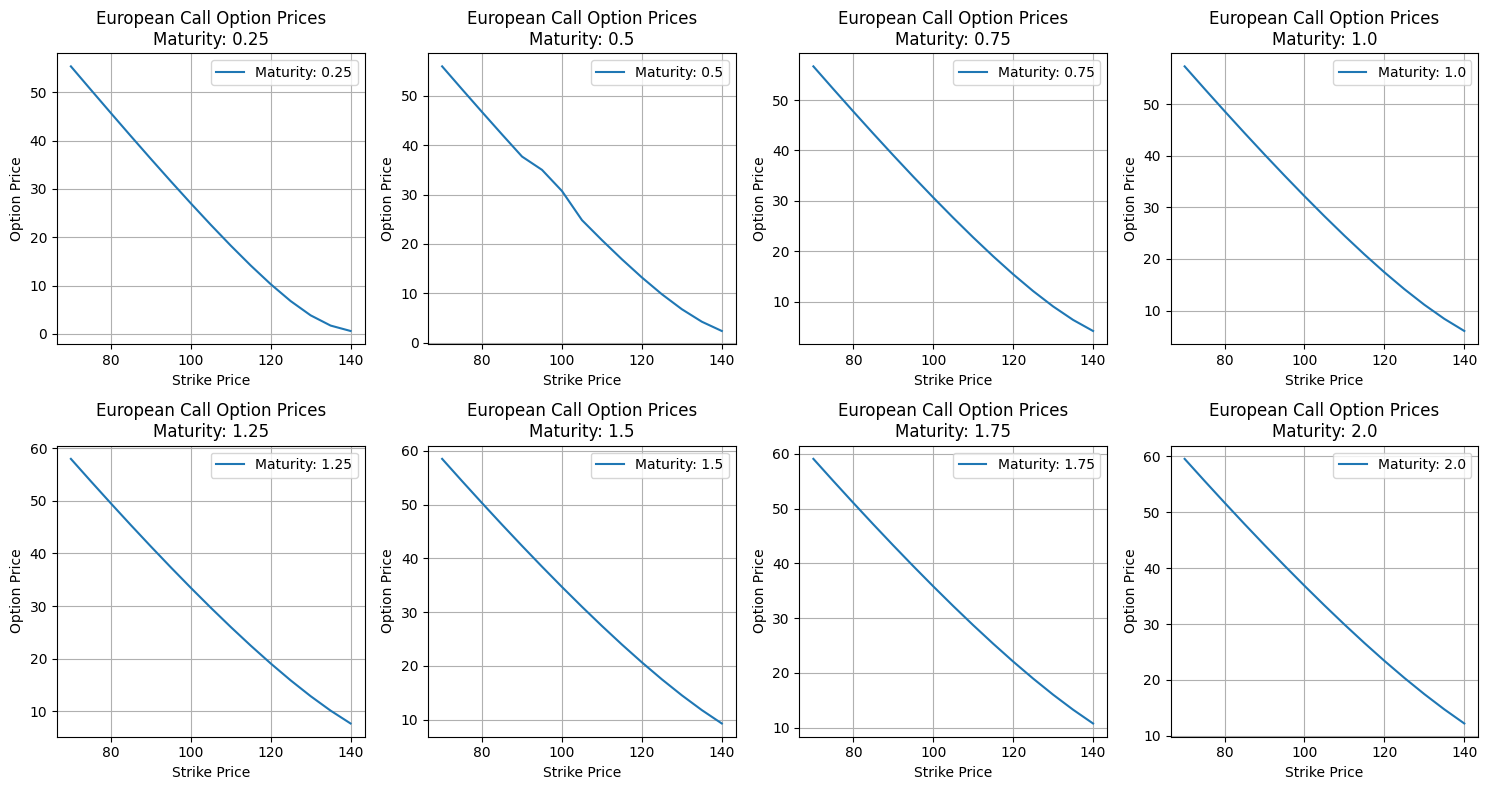

In [13]:
maturities = df3['TTM'].unique()

num_maturities = len(maturities)
cols = 4
rows = (num_maturities // cols) + (num_maturities % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

axes = axes.flatten()

for i, maturity in enumerate(maturities):
    data = df3[df3['TTM'] == maturity]
    axes[i].plot(data['Strike'], data['Call'], label=f'Maturity: {maturity}')
    axes[i].set_title(f'European Call Option Prices\nMaturity: {maturity}')
    axes[i].set_xlabel('Strike Price')
    axes[i].set_ylabel('Option Price')
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

This time we observe for maturity = 0.5 that some call options are slightly mispriced (most likely 95 and 100).

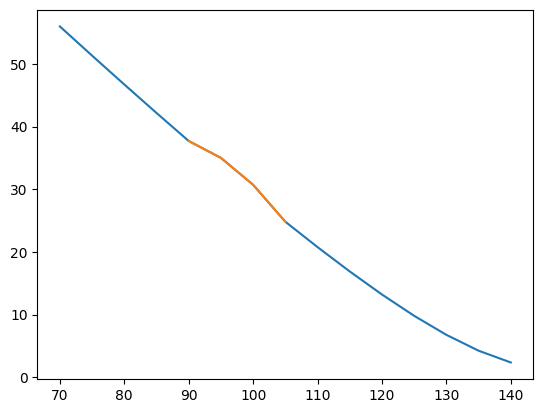

In [14]:
plt.plot(df3[df3["TTM"] == 0.5]["Strike"], df3[df3["TTM"] == 0.5]["Call"])
plt.plot(df3[(df3["TTM"] == 0.5) & (df3["Strike"] >=90)& (df3["Strike"] <=105)]["Strike"],df3[(df3["TTM"] == 0.5) & (df3["Strike"] >=90)& (df3["Strike"] <=105)]["Call"])

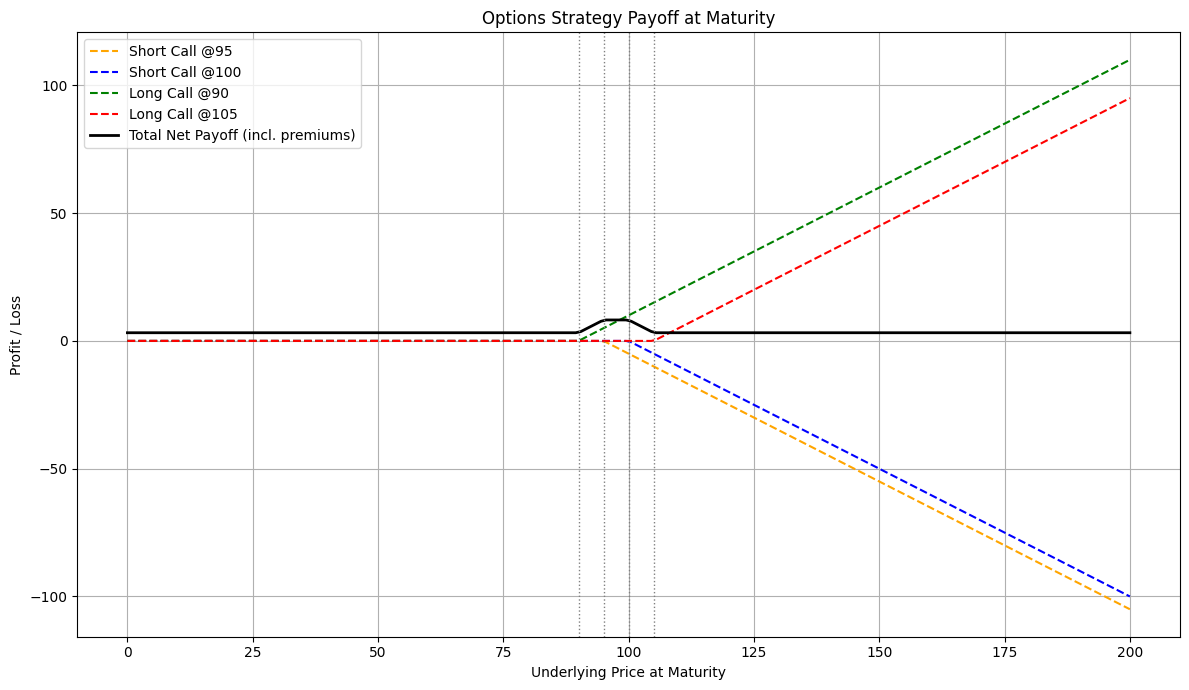

In [15]:
K1 = 95
K2 = 100
K3 = 90
K4 = 105

T = 0.75

call_K1 = df3[(df3["TTM"] == 0.5) & (df3["Strike"] == K1)]["Call"].values[0]
call_K2 = df3[(df3["TTM"] == 0.5) & (df3["Strike"] == K2)]["Call"].values[0]
call_K3 = df3[(df3["TTM"] == 0.5) & (df3["Strike"] == K3)]["Call"].values[0]
call_K4 = df3[(df3["TTM"] == 0.5) & (df3["Strike"] == K4)]["Call"].values[0]

S = np.linspace(0, 200, 200)

payoff_call_K1 = -np.maximum(S - K1, 0)
payoff_call_K2 = -np.maximum(S - K2, 0)
payoff_call_K3 = np.maximum(S - K3, 0)
payoff_call_K4 = np.maximum(S - K4, 0)

payoff_total = payoff_call_K1 + payoff_call_K2 + payoff_call_K3 + payoff_call_K4

initial_cost = call_K1 + call_K2 - call_K3 - call_K4

total_payoff_net = payoff_total + initial_cost

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(S, payoff_call_K1, label=f'Short Call @{K1}', linestyle='--', color='orange')
ax.plot(S, payoff_call_K2, label=f'Short Call @{K2}', linestyle='--', color='blue')
ax.plot(S, payoff_call_K3, label=f'Long Call @{K3}', linestyle='--', color='green')
ax.plot(S, payoff_call_K4, label=f'Long Call @{K4}', linestyle='--', color='red')

ax.plot(S, total_payoff_net, label='Total Net Payoff (incl. premiums)', color='black', linewidth=2)

ax.axvline(K1, color='gray', linestyle=':', linewidth=1)
ax.axvline(K2, color='gray', linestyle=':', linewidth=1)
ax.axvline(K3, color='gray', linestyle=':', linewidth=1)
ax.axvline(K4, color='gray', linestyle=':', linewidth=1)
    

ax.set_title("Options Strategy Payoff at Maturity")
ax.set_xlabel("Underlying Price at Maturity")
ax.set_ylabel("Profit / Loss")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


At t=0, we short a call at 95 and 100, and long a call at 90 and 105. The initial profit is 3.1999999999999993
At maturity if:
 -The underlying price is bellow 90, we don't get any payoff
 -The underlying price is between 90 and 95, we get an additional payoff of ST-90>=0
 -The underlying price is between 95 and 100, we get an additional payoff of 5
 -The underlying price is between 100 and 105, we get an additional payoff of 5+100-ST>=0
 -The underlying price is above 105, we don't get any payoff
Hence we get a riskless profit no matter the underlying price at maturity with a short call butterfly spread.

In [16]:
df4 = pd.read_csv("options4.csv")
df4 = df4.sort_values(["Time to maturity"]).reset_index(drop=True)
df4

,Strike,Time to maturity,Call
0,150,0.25,12.561038
1,150,0.50,18.055981
2,150,0.75,22.360240
3,150,1.00,21.719045
4,150,1.25,24.524143
5,150,1.50,27.091437
6,150,1.75,29.475575
7,150,2.00,31.712346


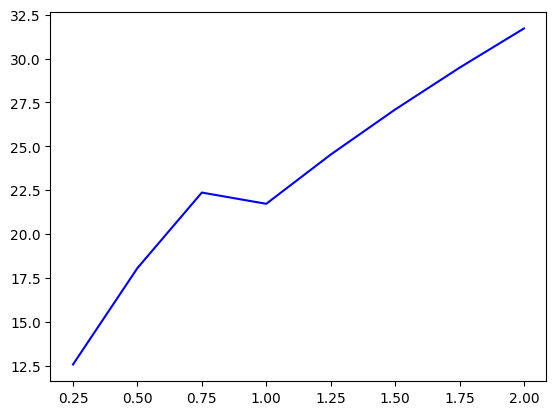

In [17]:
plt.plot(df4["Time to maturity"], df4["Call"], label="Call", color="blue")

Visually we identify a mispriced option at maturity = 0.75 as Call(150, 0.75) > Call(150, 1.0). To lock in a riskless profit we can buy the call with maturity = 1 and sell the call with maturity = 0.75.
At t=0 we get a profit of 0.64.
At t=0.75 if the stock price is less than 150 we don't have any additional loss, so at t=1.0 we will have a profit of at least 0.64.
at t=0.75 if the stock price is above 150 we will have an additional profit loss ST-150 for Call(150, 0.75) but we know that a call option price cannot be less than St-K, so Call(150, 1.0) >= ST-150 that cover the loss of Call(150, 0.75).
Hence we have a riskless profit.